## Simple Baseline

Stripped down architecture consisting of a single GMEdgeConv and clustering. Dataset will consist of 5 examples. 

1. Build a one‑layer GMEdgeConv to be a feature extractor.
2. Head: small MLP to predict per‑vertex displacements.
3. Cluster displaced vertices via mean‑shift to joint coordinates. "Naive attention" (all values are 1)=
4. Loss: Chamfer distance between predicted and ground‑truth joints.

In [2]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '../utils')

In [3]:
import open3d as o3d
import numpy as np

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch_scatter import scatter_max

import matplotlib.pyplot as plt

import random
import pickle
from tqdm import tqdm

from mean_shift_clustering import mean_shift_clustering, mode_extraction

In [5]:
def points_to_spheres(points, color=[0, 1, 1]):
    spheres = []
    for (x, y, z) in np.asarray(points):
        sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.01)
        sphere.translate((x, y, z))
        sphere.paint_uniform_color(color)
        spheres.append(sphere)
    
    return spheres

def visualize_mesh_graph(vertices: np.ndarray,
                        edge_list: np.ndarray,
                        joints_gt: np.ndarray = None, 
                        joints_pred: np.ndarray = None,
                        mesh: o3d.geometry.TriangleMesh = None):

    pts = vertices.astype(dtype=np.float64)
    lines = edge_list.astype(dtype=np.int32)
    
    line_set = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(pts),
        lines=o3d.utility.Vector2iVector(lines)
    )

    colors = [[1.0, 0.0, 0.0] for _ in lines]
    line_set.colors = o3d.utility.Vector3dVector(colors)
    
    to_draw = []
    to_draw.append(line_set)

    if joints_gt is not None:
        to_draw.extend(points_to_spheres(joints_gt, color=[0, 1, 1]))
    
    if joints_pred is not None:
        to_draw.extend(points_to_spheres(joints_pred, color=[1, 0, 1]))

    if mesh is not None:
        mesh.compute_vertex_normals()
        mesh.paint_uniform_color([0.8, 0.8, 0.8])
        to_draw.append(mesh)
    
    o3d.visualization.draw_geometries(to_draw,
                                      mesh_show_back_face=True,
                                      window_name="Mesh Graph",
                                      width=800, height=600)

### Simple Baseline

In [6]:
TRAIN_SIZE = 20
VAL_SIZE = 5

In [7]:
class RigNetDataset(Dataset):
    def __init__(self, file_path, transform=None, seed=42, train=True):

        with open(file_path, 'rb') as f:
            data = pickle.load(f)

        random.Random(seed).shuffle(data)

        if train:
            self.examples = data[:TRAIN_SIZE]
        else:
            self.examples = data[TRAIN_SIZE:TRAIN_SIZE + VAL_SIZE]

        self.transform = transform

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, index):
        sample = self.examples[index]
        if self.transform is not None:
            sample = self.transform(sample)
        return sample


In [8]:
# Use Val set for training for faster loading, then we'll use test set for testing
TRAIN_FILE_PATH = "../data/ModelResource_RigNetv1_preproccessed/mesh_graphs/val.pkl"
VAL_FILE_PATH = "../data/ModelResource_RigNetv1_preproccessed/mesh_graphs/test.pkl"
train_dataset = RigNetDataset(TRAIN_FILE_PATH, seed=0)
val_dataset = RigNetDataset(VAL_FILE_PATH, seed=1)
train_dataset[0].keys()

dict_keys(['obj_path', 'vertices', 'one_ring', 'centroid', 'geodesic', 'joints'])

### Network Architecture

#### GMEdgeConv
- Input: vertices of in_dim, one-ring edge list and geodesic edge list

Process: MLP(max(MLP(one-ring)) | max(MLP(geodesic)))

- output: vertices of out_dim

In [19]:
class GMEdgeConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        in_channels:  F_in, dimension of input vertex features
        out_channels: F_out, dimension of output vertex features
        """
        super().__init__()
        hidden = out_channels 
        # Edge MLPs for topo and geo neighborhoods
        self.mlp_topo = nn.Sequential(
            nn.Linear(2*in_channels, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU()
        )
        self.mlp_geo = nn.Sequential(
            nn.Linear(2*in_channels, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU()
        )
        # Fuse MLP to combine topo+geo pooled features
        self.mlp_fuse = nn.Sequential(
            nn.Linear(2*hidden, out_channels),
            nn.ReLU()
        )

    def forward(self, x, edge_index_topo, edge_index_geo):

        N, F_in = x.shape

        # --- one-ring ---

        # [E_topo] (num one-ring/topological edges)
        i_t, j_t = edge_index_topo  

        # Index all xi-xj vertex pairs
        xi = x[i_t] # [E_topo, F_in]
        xj = x[j_t] # [E_topo, F_in]
        edge_feat_t = torch.cat([xi, xj - xi], dim=1) # [E_topo, 2*F_in]
        # Apply topological convolutional mlp
        edge_feat_t = self.mlp_topo(edge_feat_t) # [E_topo, hidden]

        # Pool max over neighbors per i_t
        # During mesh graph creation, it was guaranteed that each vertex has at least one neighbor (itself)
        topo_pooled, _ = scatter_max(edge_feat_t, i_t, dim=0, dim_size=N)

        # --- geodesic edges ---
        i_g, j_g = edge_index_geo
        xi_g = x[i_g]
        xj_g = x[j_g]
        edge_feat_g = torch.cat([xi_g, xj_g - xi_g], dim=1)  # [E_geo, 2*F_in]
        edge_feat_g = self.mlp_geo(edge_feat_g) # [E_geo, hidden]

        geo_pooled, _ = scatter_max(edge_feat_g, i_g, dim=0, dim_size=N)
        # geo_pooled: [N, hidden]

        # --- fuse ---
        combined = torch.cat([topo_pooled, geo_pooled], dim=1)  # [N, 2*hidden]
        x_out = self.mlp_fuse(combined) # [N, out_channels]

        return x_out


### Simple JointNet (Sanity Check)

In [98]:
class SimpleJointNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = GMEdgeConv(in_channels=3, out_channels=64)
        self.disp_head = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 3)
        )
    def forward(self, x, edges_topo, edges_geo):
        # x: [N,3]
        N, D = x.shape
        feat = self.conv(x, edges_topo, edges_geo) # [N,64]
        disp = self.disp_head(feat) # [N,3]
        q = x + disp # displaced points [N,3]

        # cluster
        attention = torch.ones(N)
        # h=0.057 learned in paper
        T_pred = mean_shift_clustering(q, attention, h=0.057)
        T_pred = mode_extraction(T_pred, attention, h=0.057)
        return T_pred

In [41]:
def chamfer_loss(T_pred, T_gt):
    # T_pred: [K,3], T_gt: [M,3]
    # compute pairwise distances [K, M]
    # Distance between two arbitrary point clouds
    d2 = torch.cdist(T_pred, T_gt, p=2)  
    loss = d2.min(dim=1)[0].mean() + d2.min(dim=0)[0].mean()
    return loss

### Train Method

In [13]:
def train(model, optimizer, epochs, dataset):

    losses = []
    for _ in tqdm(range(epochs)):

        loss_sum = 0
        iters = 0
        for i in range(len(dataset)):
            G = dataset[i]

            verts = torch.FloatTensor(G['vertices'])
            one_ring = torch.LongTensor(G['one_ring']).view(2, -1)
            geodesic = torch.LongTensor(G['geodesic']).view(2, -1)
            joints_gt = torch.FloatTensor(G["joints"])

            joints_pred = model.forward(verts, one_ring, geodesic)
            loss = chamfer_loss(joints_pred, joints_gt)
            loss_sum += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            iters += 1
        
        avg_loss = loss_sum / iters
        losses.append(avg_loss)

    plt.figure()
    plt.title("loss over epochs")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.semilogy(losses)

### Training

In [105]:
G = train_dataset[0]
verts = torch.FloatTensor(G['vertices'])
one_ring = torch.LongTensor(G['one_ring'])
geodesic = torch.LongTensor(G['geodesic'])
joints_gt = torch.FloatTensor(G["joints"])

verts.shape, one_ring.shape

(torch.Size([761, 3]), torch.Size([4977, 2]))

In [113]:
model = SimpleJointNet()

100%|██████████| 50/50 [01:42<00:00,  2.05s/it]


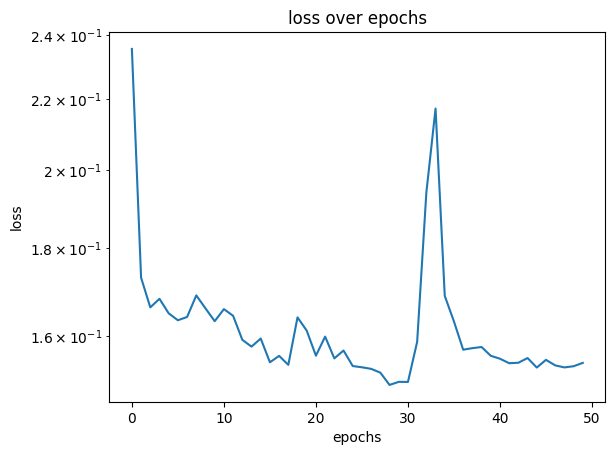

In [114]:
epochs = 50
lr = 1e-3 # from paper
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train(model, optimizer, epochs, train_dataset)


### Validate Method

In [12]:
def validate_model(model, dataset):
    loss_sum = 0
    iters = 0
    for i in range(len(dataset)):
        G = dataset[i]

        verts = torch.FloatTensor(G['vertices'])
        one_ring = torch.LongTensor(G['one_ring']).view(2, -1)
        geodesic = torch.LongTensor(G['geodesic']).view(2, -1)
        joints_gt = torch.FloatTensor(G["joints"])

        joints_pred = model.forward(verts, one_ring, geodesic)
        loss = chamfer_loss(joints_pred, joints_gt)
        loss_sum += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        iters += 1

    return loss_sum / iters

### Model Validation

In [116]:
untrained_model = SimpleJointNet()

untrained_loss = validate_model(untrained_model, val_dataset)
trained_loss = validate_model(model, val_dataset)

print(f'Untrained Model | Validation Loss: {untrained_loss:.4e}')
print(f'Trained Model   | Validation Loss: {trained_loss:.4e}')

# Scientific Notation

Untrained Model | Validation Loss: 3.3388e-01
Trained Model   | Validation Loss: 1.3608e-01


In [141]:
G = train_dataset[0]
verts = torch.FloatTensor(G['vertices'])
one_ring = torch.LongTensor(G['one_ring'])
geodesic = torch.LongTensor(G['geodesic'])
joints_gt = torch.FloatTensor(G["joints"])

In [142]:
joints_pred = model(verts, one_ring.view(2, -1), geodesic.view(2, -1))

print(len(joints_pred), len(joints_gt))

visualize_mesh_graph(verts.detach().numpy(), 
                     one_ring.detach().numpy(), 
                     joints_gt.detach().numpy(), 
                     joints_pred.detach().numpy())


34 16


### Val dataset 

Visualize output difference between trained and untrained models

In [147]:
G = val_dataset[0]
verts = torch.FloatTensor(G['vertices'])
one_ring = torch.LongTensor(G['one_ring'])
geodesic = torch.LongTensor(G['geodesic'])
joints_gt = torch.FloatTensor(G["joints"])

In [150]:
joints_pred = model(verts, one_ring.view(2, -1), geodesic.view(2, -1))

visualize_mesh_graph(verts.detach().numpy(), 
                     one_ring.detach().numpy(), 
                     joints_gt.detach().numpy(), 
                     joints_pred.detach().numpy())

In [151]:
joints_pred = untrained_model(verts, one_ring.view(2, -1), geodesic.view(2, -1))

visualize_mesh_graph(verts.detach().numpy(), 
                     one_ring.detach().numpy(), 
                     joints_gt.detach().numpy(), 
                     joints_pred.detach().numpy())

### Val dataset 

Visualize output difference between trained and untrained models

In [ ]:
G = val_dataset[1]
verts = torch.FloatTensor(G['vertices'])
one_ring = torch.LongTensor(G['one_ring'])
geodesic = torch.LongTensor(G['geodesic'])
joints_gt = torch.FloatTensor(G["joints"])

In [ ]:
joints_pred = model(verts, one_ring.view(2, -1), geodesic.view(2, -1))

visualize_mesh_graph(verts.detach().numpy(), 
                     one_ring.detach().numpy(), 
                     joints_gt.detach().numpy(), 
                     joints_pred.detach().numpy())

In [ ]:
joints_pred = untrained_model(verts, one_ring.view(2, -1), geodesic.view(2, -1))

visualize_mesh_graph(verts.detach().numpy(), 
                     one_ring.detach().numpy(), 
                     joints_gt.detach().numpy(), 
                     joints_pred.detach().numpy())

### Building towards full JointNet

GMEdgeNet:
- 3 stacked GMEdgeConv Layers. 3 -> 64 -> 256 -> 512. 
    - Concat Per Point: 835. (Local Encoding)
    - Max Pool each Layer + Concat: 832 (Global Encoding)
        - Project up to 1024 (MLP[832, 1024])
    - Concat local + global encoding per point: 835+1024=1859
    - Final projection
        - Disp head: [1859, 1024, 256, 3]
        - attention head: [1859, 1024, 256, 1]

In [20]:
G = train_dataset[0]
G.keys()

dict_keys(['obj_path', 'vertices', 'one_ring', 'centroid', 'geodesic', 'joints'])

In [21]:
verts = torch.FloatTensor(G['vertices'])
one_ring = torch.LongTensor(G['one_ring']).view(2, -1)
geodesic = torch.LongTensor(G['geodesic']).view(2, -1)
joints_gt = torch.FloatTensor(G["joints"])

In [22]:
conv1 = GMEdgeConv(3, 64)
conv2 = GMEdgeConv(64, 256)
conv3 = GMEdgeConv(256, 512)

global_mlp = nn.Sequential(
    nn.Linear(832, 1024),
    nn.ReLU()
)

disp_head = nn.Sequential(
    nn.Linear(1859, 1024),
    nn.ReLU(),
    nn.Linear(1024, 256),
    nn.ReLU(),
    nn.Linear(256, 3), 
    # No final activation. Outputs should be unconstrained
)

In [23]:
out64 = conv1(verts, one_ring, geodesic)
out256 = conv2(out64, one_ring, geodesic)
out512 = conv3(out256, one_ring, geodesic)

out512.shape

torch.Size([761, 512])

In [24]:
# Concat
x832 = torch.cat([out64, out256, out512], dim=1)
x832.shape

torch.Size([761, 832])

In [25]:
# Channelwise pooling
# Want to "reduce" the selected dimension.
# In this case, "reduce" (max) over rows (vertices)
# Channelwise max: [832]
x832_max, x832_max_idxs = torch.max(x832, dim=0)
x832_max.shape

torch.Size([832])

In [26]:
# Project from 832 -> 1024
glob1024 = global_mlp(x832_max)
glob1024.shape

torch.Size([1024])

In [27]:
# Concat per point
x835 = torch.cat([verts, x832], dim=1)
x835.shape

torch.Size([761, 835])

In [28]:
# Broadcast glob1024 from [1024] to [N, 1024]
N, D = verts.shape
glob1024.expand(N, 1024).shape

torch.Size([761, 1024])

In [29]:
# Tile and concat
x1859 = torch.cat([x835, glob1024.expand(N, 1024)], dim=1)
x1859.shape

torch.Size([761, 1859])

In [30]:
# Output displacements
q = disp_head(x1859)
q.shape

torch.Size([761, 3])

**Remaining**
- Additional supervision for attention module (Creating a binary mask for vertices whose values are equal to 1 for vertices closest to joints. Heuristic for "closest" described in paper)
    - We use cross-entropy to measure consistency between these masks and neural attention.
- Random dropout of upto 15 edges in geodesic neighborhoods
    - Why just here? Why just 15?
    - Paper found that it improved performance. Simulates vertex sampling on the mesh, thus making the graph more robust to different tesselations. 
- User control 
    - Allow overriding h in range [0.01, 0.1] for user-control over number of joints

**Training Impl. Details**
- First pre-train $w_a$ (attention module params) with specific attention loss. This helps performance. Then fine-tune $w_a$ and train $w_d$ and $h$ with sum of two chamfer losses - one which includes $h$ and $w_a$ as params with $w_d$, and one that has $w_d$ as params exclusively. 
- Finetuning: Batch size = 2, Adam optimizer, lr=10e-6

### GMEdge Net Architecture

Hard-coding MLP hidden sizes based on joint prediction section of appendix. Bone-net also uses GMEdgeNets with different hidden layer combinations, but we don't worry about that right now.

In [31]:
class GMEdgeNet(nn.Module):

    def __init__(self, out=3):

        super().__init__()

        self.conv1 = GMEdgeConv(3, 64)
        self.conv2 = GMEdgeConv(64, 256)
        self.conv3 = GMEdgeConv(256, 512)

        self.global_mlp = nn.Sequential(
            nn.Linear(832, 1024),
            nn.ReLU()
        )

        self.head = nn.Sequential(
            nn.Linear(1859, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, out), 
            # No final activation. Outputs should be unconstrained
        )

    def forward(self, verts, one_ring, geodesic):

        N, D = verts.shape

        out64 = self.conv1(verts, one_ring, geodesic)
        out256 = self.conv2(out64, one_ring, geodesic)
        out512 = self.conv3(out256, one_ring, geodesic)

        x832 = torch.cat([out64, out256, out512], dim=1)

        # Channelwise max: [832]
        x832_max, x832_max_idxs = torch.max(x832, dim=0)

        x835 = torch.cat([verts, x832], dim=1)
        glob1024 = self.global_mlp(x832_max)

        x1859 = torch.cat([x835, glob1024.expand(N, 1024)], dim=1)
        out = self.head(x1859)
        
        return out

In [32]:
gmedgenet = GMEdgeNet(out=3)
out = gmedgenet(verts, one_ring, geodesic)
out.shape

torch.Size([761, 3])

### Full JointNet Architecture

In [42]:
class JointNet(nn.Module):
    def __init__(self, is_training=True):
        super().__init__()
        self.disp_head = GMEdgeNet(out=3)
        self.attn_head = GMEdgeNet(out=1)
        self.h = nn.Parameter(torch.tensor(0.05), requires_grad=True)

        self.max_iters=50
        if is_training:
            self.max_iters=20

    def forward(self, x, edges_topo, edges_geo):
        # x: [N,3]
        N, D = x.shape

        disp = self.disp_head(x, edges_topo, edges_geo) # [N,3]
        q = x + disp # displaced points [N,3]

        # cluster
        attn = self.attn_head(x, edges_topo, edges_geo)
        
        # This is making loss erratic
        # h = 0.057

        # max-iters during training: ~10-20 in paper
        T_pred = mean_shift_clustering(q, attn, self.h, max_iters=self.max_iters)
        T_pred = mode_extraction(T_pred, attn, self.h)
        return T_pred

In [43]:
full_model = JointNet()

100%|██████████| 60/60 [07:09<00:00,  7.16s/it]


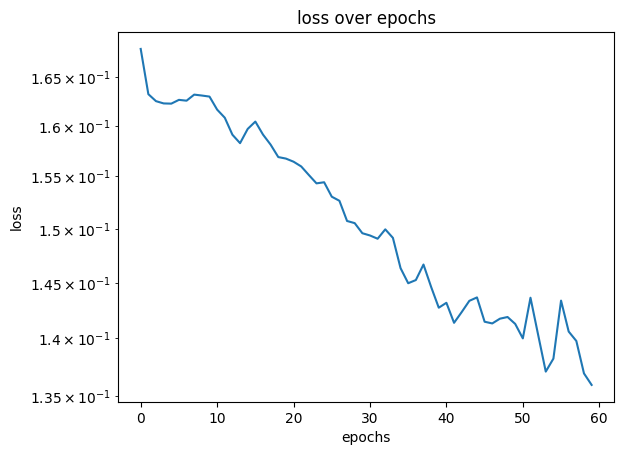

In [44]:
epochs = 60
# So far, 70. 
# Loss starts to climb at 65.

# 1e-3 too high, loss spikes randomly
lr=1e-4
optimizer = torch.optim.Adam(full_model.parameters(), lr=lr)

# Their batch size is 2, so just doing 1 example per batch isn't too bad. 
train(full_model, optimizer, epochs, train_dataset)

In [171]:
untrained_model = JointNet()

full_model.max_iters = 50
untrained_model.max_iters = 50

untrained_loss = validate_model(untrained_model, val_dataset)
trained_loss = validate_model(full_model, val_dataset)

print(f'Untrained Model | Validation Loss: {untrained_loss:.4f}')
print(f'Trained Model   | Validation Loss: {trained_loss:.4f}')

# Scientific Notation

Untrained Model | Validation Loss: 0.1941
Trained Model   | Validation Loss: 0.1279


### Val dataset on full model

Visualize output difference between trained and untrained models

In [172]:
G = val_dataset[1]
verts = torch.FloatTensor(G['vertices'])
one_ring = torch.LongTensor(G['one_ring'])
geodesic = torch.LongTensor(G['geodesic'])
joints_gt = torch.FloatTensor(G["joints"])

In [173]:
joints_pred = full_model(verts, one_ring.view(2, -1), geodesic.view(2, -1))

visualize_mesh_graph(verts.detach().numpy(), 
                     one_ring.detach().numpy(), 
                     joints_gt.detach().numpy(), 
                     joints_pred.detach().numpy())

In [ ]:
joints_pred = untrained_model(verts, one_ring.view(2, -1), geodesic.view(2, -1))

visualize_mesh_graph(verts.detach().numpy(), 
                     one_ring.detach().numpy(), 
                     joints_gt.detach().numpy(), 
                     joints_pred.detach().numpy())

: 